# Testing various methods for analyzing and visualizing CAM-SE output in Python

Authors/Contributors:
---------------------
* Katie Dagon
* Teagan King
* John Truesdale
* Colin Zarzycki
* Deepak Cherian
* Steve Yeager

## Import libraries

In [41]:
import xarray as xr
import scipy as sp
import numpy as np
import xesmf

## Dask cluster

In [7]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '5GiB' # PBSCluster specification
nmem2 = '5GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize
    local_directory='/glade/scratch/$USER/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36121 instead
  warnings.warn(


In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36121/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36121/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:43062,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/36121/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
map_path = '/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/'
map_file='map_ne120_to_0.23x0.31_bilinear.nc'

In [6]:
datadir = '/glade/scratch/tking/cgnet/rcp85_2086_2100/PS/'
file = 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2080010100Z-2080123121Z.nc'  # PS files are 3hourly avg from 2080-2100

## Regrid CAM-SE output using map file

https://github.com/UXARRAY/uxarray/issues/183#issuecomment-1343388433

### Read in ESMF map file

In [9]:
map_path = '/glade/campaign/cgd/amp/jet/ClimateNet/data_processing/maps/'
map_file='map_ne120_to_0.23x0.31_bilinear.nc'
xwgt=xr.open_dataset(map_path+map_file)
xwgt

<xarray.Dataset>
Dimensions:        (src_grid_rank: 1, dst_grid_rank: 2, n_a: 777602,
                    n_b: 884736, nv_a: 3, nv_b: 4, n_s: 2654208)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a,
                                nv_b, n_s
Data variables: (12/19)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    col            (n_s) int32 ...
    row            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes:
    title:               ESMF Offline Regridding Weight Generator
    normalization:       destarea
    map_method:          Bilinear remapping
    ESMF_regrid_method:  Bilinear
    conventions:         NCAR-CSM
    domain_a:            /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    domain_b:            /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    grid_file_src:       /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    grid_file_dst:       /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    CVS_revision:        6.3.0r

### Make source / destination grids

In [10]:
srclat=xwgt['yc_a']
srclon=xwgt['xc_a']
dstlat=xwgt['yc_b']
dstlon=xwgt['xc_b']
src_grid_dims=xwgt['src_grid_dims'].values
dst_grid_dims=xwgt['dst_grid_dims'].values

print("Src grid dims: {0}, dst grid dims: {1}".format(src_grid_dims, dst_grid_dims))

n_a = xwgt['n_a'].size # col dimension
n_b = xwgt['n_b'].size # row dimension
n_s = xwgt['n_s'].size # nnz dimension

print("Map contains {0} rows, {1} cols and {2} nnz values".format(n_b, n_a, n_s))

rows = xwgt['row'][:] - 1 # row indices (1-based)
cols = xwgt['col'][:] - 1 # col indices (1-based)
nnzvals = xwgt['S'][:] # nnz map values

Src grid dims: [777602], dst grid dims: [1152  768]
Map contains 884736 rows, 777602 cols and 2654208 nnz values


### Create sparse matrix map

In [11]:
sparse_map = sp.sparse.coo_matrix((nnzvals, (rows,cols)),shape=(n_b,n_a))
sparse_map

<884736x777602 sparse matrix of type '<class 'numpy.float64'>'
	with 2654208 stored elements in COOrdinate format>

### Read in CAM-SE output file
Testing with surface pressure (PS)

In [12]:
datadir = '/glade/scratch/tking/cgnet/rcp85_2086_2100/PS/'
file = 'b.e13.BRCP85C5CN.ne120_g16.003a.cam.h3.PS.2080010100Z-2080123121Z.nc'  # PS files are 3hourly avg from 2080-2100

In [13]:
psfile = xr.open_dataset(datadir+file, chunks={"time": 50, "ncol": 50000})
psfile

<xarray.Dataset>
Dimensions:       (ncol: 777602, ilev: 31, lev: 30, time: 2920, nbnd: 2)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time          (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/31)
    P0            float64 ...
    area          (ncol) float64 dask.array<chunksize=(50000,), meta=np.ndarray>
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    ...            ...
    nscur         (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(50, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(50,), meta=np.ndarray>
    PS            (time, ncol) float32 dask.array<chunksize=(50, 50000), meta=np.ndarray>
Attributes: (12/14)
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.BRCP85C5CN.ne120_g16.003a
    title:            UNSET
    ...               ...
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /global/project/projectdirs/ccsm1/inputdata/atm/cam/ini...
    topography_file:  /global/project/projectdirs/ccsm1/inputdata/atm/cam/top...
    history:          Thu Feb  4 14:44:15 2021: /global/common/sw/cray/cnl7/h...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

In [14]:
ps = psfile.PS
ps

<xarray.DataArray 'PS' (time: 2920, ncol: 777602)>
dask.array<open_dataset-3b9c1b90db6f1b609596052f2dc34a24PS, shape=(2920, 777602), dtype=float32, chunksize=(50, 50000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean

### Apply sparse map onto first timestep of PS
Note this is the time consuming step, so sticking to one time index for now

In [17]:
%%time
## Now apply map onto a src column vector length n_a to compute vector length n_b
field_target = sparse_map @ ps.isel(time=0)

CPU times: user 656 ms, sys: 41 ms, total: 697 ms
Wall time: 9.22 s


In [19]:
field_target.shape

(884736,)

### Reshape 1-D vector to destination grid

In [22]:
data_out = np.reshape(field_target, dst_grid_dims, order='F')
print("Reshaped array now has dimensions {0}".format(dst_grid_dims, n_a, n_s))

Reshaped array now has dimensions [1152  768]


### Reshape destination grid to build structured xarray data array

In [23]:
lat2d = np.reshape(dstlat.values, dst_grid_dims, order='F')
lon2d = np.reshape(dstlon.values, dst_grid_dims, order='F')

In [29]:
print(lat2d.shape, lon2d.shape)

(1152, 768) (1152, 768)


### Build data array with dimension and coordinates

In [33]:
ps_remap = xr.DataArray(
    data=data_out,
    dims=["lon", "lat"],
    coords=dict(
        lon=(["lon"], lon2d[:,0]),
        lat=(["lat"], lat2d[0,:]),
    )
)

In [34]:
ps_remap

<xarray.DataArray (lon: 1152, lat: 768)>
array([[ 68807.5       ,  69001.86457198,  69202.08789873, ...,
        100625.24709955, 100596.39075781, 100567.359375  ],
       [ 68807.5       ,  68999.65652929,  69197.67184182, ...,
        100624.82442162, 100596.17941786, 100567.359375  ],
       [ 68807.5       ,  68997.44259632,  69193.24400512, ...,
        100624.40003958, 100595.96722582, 100567.359375  ],
       ...,
       [ 68807.5       ,  69006.61953517,  69211.59768151, ...,
        100626.60203723, 100597.06823691, 100567.359375  ],
       [ 68807.5       ,  69005.04058247,  69208.43982378, ...,
        100626.1521306 , 100596.84328019, 100567.359375  ],
       [ 68807.5       ,  69003.45557902,  69205.26986476, ...,
        100625.70048023, 100596.61745158, 100567.359375  ]])
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0

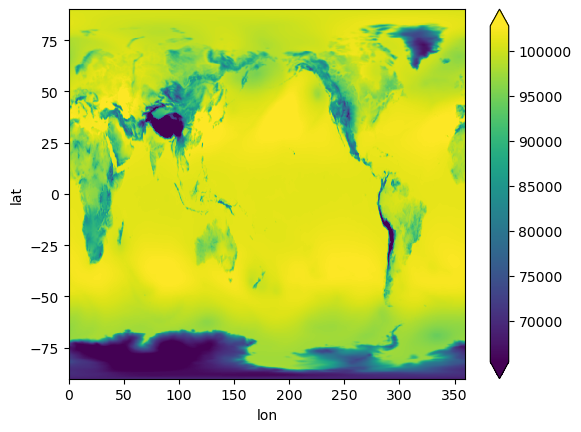

In [40]:
## Simple plot
ps_remap.plot(x="lon", y="lat", robust=True); # have to label x and y or it won't know which is which...

## Regrid CAM-SE output using xESMF
https://ncar.github.io/esds/posts/2022/cam-se-regridding/

In [11]:
def regrid_cam_se(dataset, weight_file):
    """
    Regrid CAM-SE output using an existing ESMF weights file.

    Parameters
    ----------
    dataset: xarray.Dataset
        Input dataset to be regridded. Must have the `ncol` dimension.
    weight_file: str or Path
        Path to existing ESMF weights file

    Returns
    -------
    regridded
        xarray.Dataset after regridding.
    """
    import numpy as np
    import xarray as xr

    assert isinstance(dataset, xr.Dataset)
    weights = xr.open_dataset(weight_file)

    # input variable shape
    in_shape = weights.src_grid_dims.load().data

    # Since xESMF expects 2D vars, we'll insert a dummy dimension of size-1
    if len(in_shape) == 1:
        in_shape = [1, in_shape.item()]

    # output variable shapew
    out_shape = weights.dst_grid_dims.load().data.tolist()[::-1]

    print(f"Regridding from {in_shape} to {out_shape}")

    # Insert dummy dimension
    vars_with_ncol = [name for name in dataset.variables if "ncol" in dataset[name].dims]
    updated = dataset.copy().update(
        dataset[vars_with_ncol].transpose(..., "ncol").expand_dims("dummy", axis=-2)
    )
    
    # construct a regridder
    # use empty variables to tell xesmf the right shape
    # https://github.com/pangeo-data/xESMF/issues/202
    dummy_in = xr.Dataset(
        {
            "lat": ("lat", np.empty((in_shape[0],))),
            "lon": ("lon", np.empty((in_shape[1],))),
        }
    )
    dummy_out = xr.Dataset(
        {
            "lat": ("lat", weights.yc_b.data.reshape(out_shape)[:, 0]),
            "lon": ("lon", weights.xc_b.data.reshape(out_shape)[0, :]),
        }
    )

    regridder = xesmf.Regridder(
        dummy_in,
        dummy_out,
        weights=weight_file,
        method="blah",
        reuse_weights=True,
        periodic=True,
    )
    display(regridder)

    # Actually regrid, after renaming
    regridded = regridder(updated.rename({"dummy": "lat", "ncol": "lon"}))

    # merge back any variables that didn't have the ncol dimension
    # And so were not regridded
    return xr.merge([dataset.drop_vars(regridded.variables), regridded])

psfile = xr.open_dataset(datadir+file, chunks={"time": 50, "ncol": -1})

regridded = regrid_cam_se(psfile, f"{map_path}/{map_file}")
regridded

Regridding from [1, 777602] to [768, 1152]


xESMF Regridder 
Regridding algorithm:       blah 
Weight filename:            blah_1x777602_768x1152_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (1, 777602) 
Output grid shape:          (768, 1152) 
Periodic in longitude?      True

<xarray.Dataset>
Dimensions:       (ilev: 31, lev: 30, time: 2920, nbnd: 2, lat: 768, lon: 1152)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time          (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Dimensions without coordinates: nbnd
Data variables: (12/29)
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    mdt           int32 ...
    ...            ...
    nsteph        (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(50, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(50,), meta=np.ndarray>
    area          (lat, lon) float64 dask.array<chunksize=(768, 1152), meta=np.ndarray>
    PS            (time, lat, lon) float32 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>
Attributes: (12/14)
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.BRCP85C5CN.ne120_g16.003a
    title:            UNSET
    ...               ...
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /global/project/projectdirs/ccsm1/inputdata/atm/cam/ini...
    topography_file:  /global/project/projectdirs/ccsm1/inputdata/atm/cam/top...
    history:          Thu Feb  4 14:44:15 2021: /global/common/sw/cray/cnl7/h...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

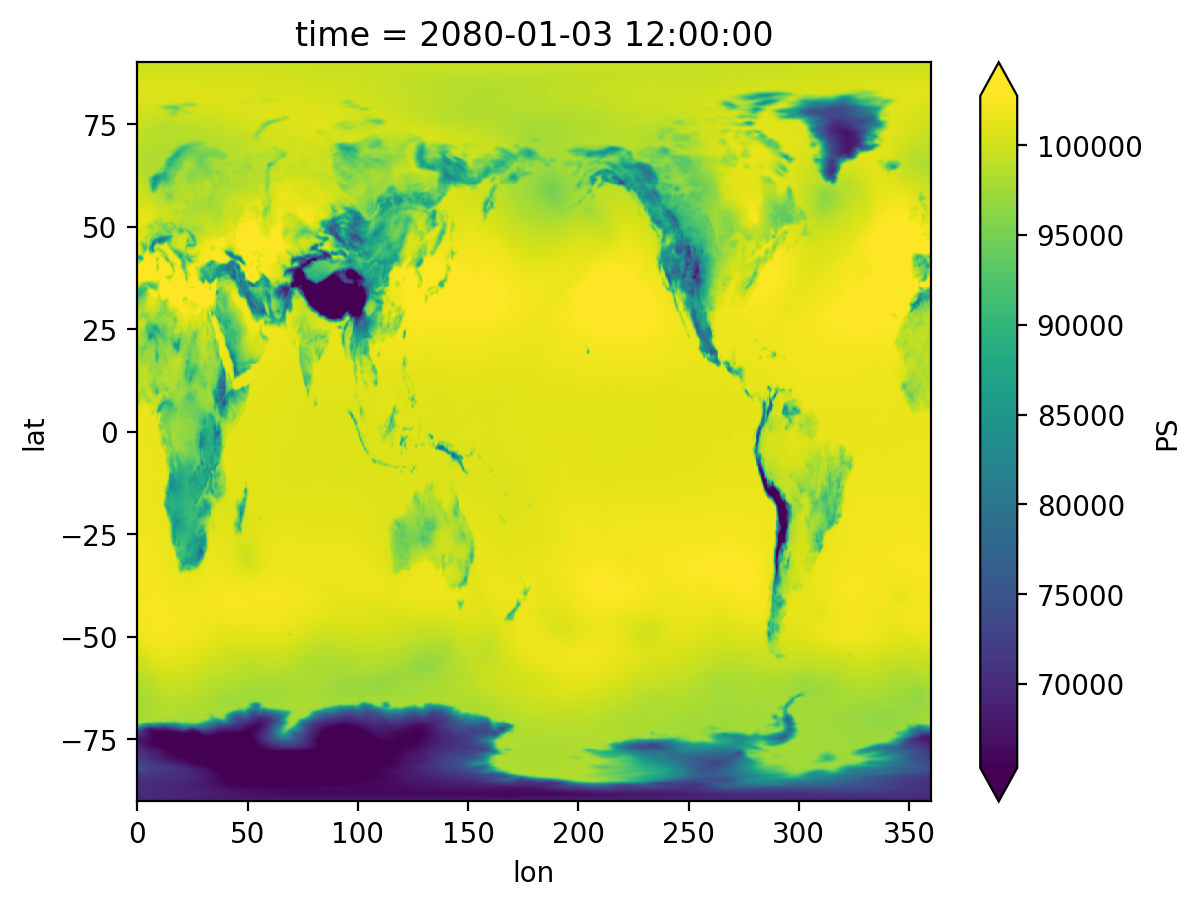

In [13]:
regridded.PS.isel(time=20).plot(robust=True)

## Direct sparse matrix multiply

Trying to take the weights, create a `pydata/sparse` matrix then use `xr.dot` (≡ `np.einsum`). 

This is identical to approaches 1, 4; but with `pydata/sparse` which in theory should work well with dask.

This *should* support chunking along `ncol` but doesn't work because of [a sparse bug](https://github.com/pydata/sparse/issues/589)

In [33]:
xwgt=xr.open_dataset(map_path+map_file)
xwgt

<xarray.Dataset>
Dimensions:        (src_grid_rank: 1, dst_grid_rank: 2, n_a: 777602,
                    n_b: 884736, nv_a: 3, nv_b: 4, n_s: 2654208)
Dimensions without coordinates: src_grid_rank, dst_grid_rank, n_a, n_b, nv_a,
                                nv_b, n_s
Data variables: (12/19)
    src_grid_dims  (src_grid_rank) int32 ...
    dst_grid_dims  (dst_grid_rank) int32 ...
    yc_a           (n_a) float64 ...
    yc_b           (n_b) float64 ...
    xc_a           (n_a) float64 ...
    xc_b           (n_b) float64 ...
    ...             ...
    area_b         (n_b) float64 ...
    frac_a         (n_a) float64 ...
    frac_b         (n_b) float64 ...
    col            (n_s) int32 ...
    row            (n_s) int32 ...
    S              (n_s) float64 ...
Attributes:
    title:               ESMF Offline Regridding Weight Generator
    normalization:       destarea
    map_method:          Bilinear remapping
    ESMF_regrid_method:  Bilinear
    conventions:         NCAR-CSM
    domain_a:            /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    domain_b:            /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    grid_file_src:       /glade/p/cgd/ccr/people/nanr/mapfiles/ne120.nc
    grid_file_dst:       /glade/p/cgd/ccr/people/nanr/mapfiles/0.23x0.31.nc
    CVS_revision:        6.3.0r

In [91]:
srclat=xwgt['yc_a']
srclon=xwgt['xc_a']
dstlat=xwgt['yc_b']
dstlon=xwgt['xc_b']
src_grid_dims=xwgt['src_grid_dims'].values
dst_grid_dims=xwgt['dst_grid_dims'].values

print("Src grid dims: {0}, dst grid dims: {1}".format(src_grid_dims, dst_grid_dims))

n_a = xwgt['n_a'].size # col dimension
n_b = xwgt['n_b'].size # row dimension
n_s = xwgt['n_s'].size # nnz dimension

print("Map contains {0} rows, {1} cols and {2} nnz values".format(n_b, n_a, n_s))

rows = xwgt['row'][:] - 1 # row indices (1-based)
cols = xwgt['col'][:] - 1 # col indices (1-based)
nnzvals = xwgt['S'][:] # nnz map values

Src grid dims: [777602], dst grid dims: [1152  768]
Map contains 884736 rows, 777602 cols and 2654208 nnz values


In [93]:
import sparse

xsparse_wgts = xr.DataArray(
    sparse.COO(
        coords=(rows, cols), 
        data=nnzvals, 
        shape=(n_b,n_a), 
        fill_value=0
      ),
    dims=("latlon", "ncol")
)
xsparse_wgts

Format,coo
Data Type,float64
Shape,"(884736, 777602)"
nnz,2654208
Density,3.858014768480534e-06
Read-only,True
Size,40.5M
Storage ratio,0.0


In [94]:
psfile = xr.open_dataset(datadir+file, chunks={"time": 50, "ncol": -1})
psfile

<xarray.Dataset>
Dimensions:       (ncol: 777602, ilev: 31, lev: 30, time: 2920, nbnd: 2)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time          (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/31)
    P0            float64 ...
    area          (ncol) float64 dask.array<chunksize=(777602,), meta=np.ndarray>
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    ...            ...
    nscur         (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(50, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(50,), meta=np.ndarray>
    PS            (time, ncol) float32 dask.array<chunksize=(50, 777602), meta=np.ndarray>
Attributes: (12/14)
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.BRCP85C5CN.ne120_g16.003a
    title:            UNSET
    ...               ...
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /global/project/projectdirs/ccsm1/inputdata/atm/cam/ini...
    topography_file:  /global/project/projectdirs/ccsm1/inputdata/atm/cam/top...
    history:          Thu Feb  4 14:44:15 2021: /global/common/sw/cray/cnl7/h...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

In [95]:
xr.dot(psfile.PS, xsparse_wgts, dims="ncol")

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/dask/array/einsumfuncs.py:233: PerformanceWarning: Increasing number of chunks by factor of 59
  result = blockwise(


TypeError: einsum() got an unexpected keyword argument 'dtype'

### Create sparse matrix map

In [11]:
sparse_map = sp.sparse.coo_matrix((nnzvals, (rows,cols)),shape=(n_b,n_a))
sparse_map

<884736x777602 sparse matrix of type '<class 'numpy.float64'>'
	with 2654208 stored elements in COOrdinate format>

## Remap function
https://github.com/sgyeager/mypyutils/blob/main/mypyutils/regrid_utils.py

In [57]:
def remap_camse(ds, dsw, varlst=[]):
    #dso = xr.full_like(ds.drop_dims('ncol'), np.nan)
    dso = ds.drop_dims('ncol').copy()
    lonb = dsw.xc_b.values.reshape([dsw.dst_grid_dims[1].values, dsw.dst_grid_dims[0].values])
    latb = dsw.yc_b.values.reshape([dsw.dst_grid_dims[1].values, dsw.dst_grid_dims[0].values])
    weights = sp.sparse.coo_matrix((dsw.S, (dsw.row-1, dsw.col-1)), shape=[dsw.dims['n_b'], dsw.dims['n_a']])
    if not varlst:
        for varname in list(ds):
            if 'ncol' in(ds[varname].dims):
                varlst.append(varname)
        if 'lon' in varlst: varlst.remove('lon')
        if 'lat' in varlst: varlst.remove('lat')
        if 'area' in varlst: varlst.remove('area')
    for varname in varlst:
        shape = ds[varname].shape
        invar_flat = ds[varname].values.reshape(-1, shape[-1])
        remapped_flat = weights.dot(invar_flat.T).T
        remapped = remapped_flat.reshape([*shape[0:-1], dsw.dst_grid_dims[1].values,
                                          dsw.dst_grid_dims[0].values])
        dimlst = list(ds[varname].dims[0:-1])
        dims={}
        coords={}
        for it in dimlst:
            dims[it] = dso.dims[it]
            coords[it] = dso.coords[it]
        dims['lat'] = int(dsw.dst_grid_dims[1])
        dims['lon'] = int(dsw.dst_grid_dims[0])
        coords['lat'] = latb[:,0]
        coords['lon'] = lonb[0,:]
        remapped = xr.DataArray(remapped, coords=coords, dims=dims, attrs=ds[varname].attrs)
        dso = xr.merge([dso, remapped.to_dataset(name=varname)])
    return dso

Note: this step can be time/memory consuming

In [59]:
out = remap_camse(data_in, xwgt)
out

<xarray.Dataset>
Dimensions:       (ilev: 31, lev: 30, time: 2920, nbnd: 2, lat: 768, lon: 1152)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time          (time) object 2080-01-01 00:00:00 ... 2080-12-31 21:00:00
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Dimensions without coordinates: nbnd
Data variables: (12/28)
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    mdt           int32 ...
    ...            ...
    nscur         (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(50,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(50, 2), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(50,), meta=np.ndarray>
    PS            (time, lat, lon) float64 6.881e+04 6.881e+04 ... 1.006e+05
Attributes: (12/14)
    np:               4
    ne:               120
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.BRCP85C5CN.ne120_g16.003a
    title:            UNSET
    ...               ...
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /global/project/projectdirs/ccsm1/inputdata/atm/cam/ini...
    topography_file:  /global/project/projectdirs/ccsm1/inputdata/atm/cam/top...
    history:          Thu Feb  4 14:44:15 2021: /global/common/sw/cray/cnl7/h...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

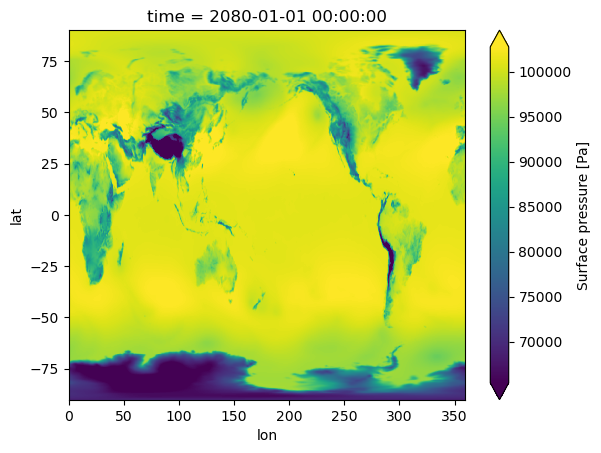

In [62]:
out.PS.isel(time=0).plot(robust=True);

## Triangulate using Datashader and Holoviews
https://github.com/UXARRAY/uxarray/issues/183#issuecomment-1343274909